# ANÁLISE 003 - POR PAÍS

## PRIMEIRA BASE DE DADOS : MOBILIDADE - GOOGLE

BASE GOOGLE  
Da mesma data que extraimos os dados para e estado de Sào Paulo, iremos extrair para BRASIL, CHILE e REINO UNIDO. Os seguintes tratamentos foram feitos ainda no Excel para acelerar a análise:
- Selecionar somente as linhas com os dados consolidados do país, ou sejam, com sub_region1 (estados/provincias) e sub_region2 (municípios) vazios.  
- Colunas: manter somente country_region (para que possamos juntar os paises analisados numa só base) e de date até o final.  
- Juntar as 6 planilhas excel numa só.

#### ATENÇÃO - a escolha do Reino Unido teve como referência o trabalho de [BASELLINI et al, 2019], que também utilizou os dados do Google Mobility Reports e, embora tenha abrangido um escopo geográfico um pouco mais restrito (apenas Inglaterra e País de Gales) mostrou um cenário bastante detalhado das medidas pelo governo britânico, no sentido de controlar o avanço da doença, em especial os índices de mortalidade da mesma. 

In [1]:
#Base resultante : BR_CL_GB_Mobility_Report.xlsx
#vamos renomear as colunas para o português conforme feito na análise para SP

In [2]:
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns 
%matplotlib inline
import pandas as pd
from scipy.stats.stats import pearsonr
from datetime import datetime  

# Ignorar warnings não prejudiciais
import warnings
warnings.filterwarnings("ignore")

ATENÇÃO, essa planilha foi montada à mão e contém os dados originais, não normalizados !

In [3]:
dados_mob = pd.read_excel('BR_CL_GB_Mobility_Report.xlsx')

Para esta massa de dados, mais adiante, limitaremos a análise ao ano de 2020, já que os procedimentos de vacinação no Reino Unido começaram ainda em dezembro (https://g1.globo.com/bemestar/vacina/noticia/2020/12/07/reino-unido-anuncia-que-vacinacao-contra-covid-19-comeca-nesta-terca-8.ghtml) e portanto já no primeiro semestre de 2021 o efeito de tais procedimentos começou a influenciar a curva de casos.

In [4]:
dados_mob.columns = ['pais', 'data', 'comercio_recreacao', 'alimentacao_farmacia', 
                'parques', 'estacoes_transporte', 'locais_trabalho', 'residencias']

In [5]:
#verificar valores ausentes nas colunas - não há lacunas a preencher
dados_mob.isna().sum()

pais                    0
data                    0
comercio_recreacao      0
alimentacao_farmacia    0
parques                 0
estacoes_transporte     0
locais_trabalho         0
residencias             0
dtype: int64

In [6]:
def filtroDataFinal(df,d):
    filtro_data = (df['data'] <= d)
    dados_data = df[filtro_data]
    return(dados_data)

In [7]:
#já faz aqui a restrição de data (31/12/2020)
dados_mob = filtroDataFinal(dados_mob,'2020-12-31')

Temos agora, então, uma base em excel contendo o período fevereiro a dezembro/2020 para a variação das categorias de mobilidade para Brasil, Chile e Grã-Bretanha.

## SEGUNDA BASE DE DADOS : OCORRÊNCIAS - OWID

Fonte de dados para casos - Brasil, Chile e Gra-Bretanha - extraido da base do site OUR WORLD IN DATA (OWID - Oxford) em 09/09/2021 - https://ourworldindata.org/explorers/coronavirus-data-explorer?zoomToSelection=true&time=2020-03-01..latest&facet=none&pickerSort=asc&pickerMetric=location&Metric=Confirmed+cases&Interval=7-day+rolling+average&Relative+to+Population=true&Align+outbreaks=false&country=BRA~CHL~GBR

A formatação da base foi feita diretamente no excel, e consistiu em : (1) exclusão das colunas que não seriam utilizadas; (2) exclusão das linhas fora do escopo desta análise (Brasil, Reino Unido e Chile); (3) inclusão da coluna da data aproximada de contaminação (utilizando o tempo médio entre contaminação e notificação de 15 dias para o Brasil, 10 dias para o Chile e 3 dias para Reino Unido).

In [8]:
dados_casos = pd.read_excel('owid-covid-data-BR-CL-UK.xlsx')
dados_casos

,location,data notiif,data,new_cases,new_deaths,new_vaccinations
0,Brazil,2020-02-26,2020-02-11,1.0,NaN,NaN
1,Brazil,2020-02-27,2020-02-12,0.0,NaN,NaN
2,Brazil,2020-02-28,2020-02-13,0.0,NaN,NaN
3,Brazil,2020-02-29,2020-02-14,1.0,NaN,NaN
4,Brazil,2020-03-01,2020-02-15,0.0,NaN,NaN
...,...,...,...,...,...,...
1707,United Kingdom,2021-09-04,2021-09-01,36725.0,120.0,169607.0
1708,United Kingdom,2021-09-05,2021-09-02,36545.0,68.0,94988.0
1709,United Kingdom,2021-09-06,2021-09-03,40976.0,45.0,102713.0
1710,United Kingdom,2021-09-07,2021-09-04,37535.0,210.0,NaN


## PRÓXIMA ETAPA: fazer o merge das bases de mobilidade e de casos acima,  amarrando por país e por data - na base de casos, deve-se utilizar a data da contaminação (aproximada)

In [9]:
dados_casos.columns

Index(['location', 'data notiif', 'data', 'new_cases', 'new_deaths',
       'new_vaccinations'],
      dtype='object')

In [10]:
dados_mob.columns

Index(['pais', 'data', 'comercio_recreacao', 'alimentacao_farmacia', 'parques',
       'estacoes_transporte', 'locais_trabalho', 'residencias'],
      dtype='object')

In [11]:
dados_casos.columns = ['pais','data_notif','data','casos novos','obitos novos','vacinacoes novas']

In [12]:
def converteTimestamp(df,col_data):

    lista = []

    for dt in df[col_data]:
        dti = datetime.strptime(str(dt), '%Y-%m-%d %H:%M:%S')
        lista.append(dti.strftime('%Y-%m-%d'))

    df[col_data] = lista
    
    return(df)

In [13]:
dados_casos = converteTimestamp(dados_casos,'data')

### JOIN

In [14]:
dados_mob_casos_BR_CL_UK = pd.merge(dados_mob, dados_casos, on=["pais","data"], how="inner")

In [15]:
#elimina a coluna dados_notif que nao tera utiilidade no momento
dados_mob_casos_BR_CL_UK = dados_mob_casos_BR_CL_UK.drop('data_notif', axis=1)

In [16]:
#preenche os valores faltantes usando o modelo MissForest (random forest)

dados_mob_casos_BR_CL_UK.isna().sum()

pais                      0
data                      0
comercio_recreacao        0
alimentacao_farmacia      0
parques                   0
estacoes_transporte       0
locais_trabalho           0
residencias               0
casos novos               0
obitos novos             59
vacinacoes novas        946
dtype: int64

In [17]:
def preencheNan(df,cols):
    
    import sklearn.neighbors._base
    import sys

    sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

    from missingpy import MissForest
    imputer = MissForest()

    X = df[cols]

    X_imputed = imputer.fit_transform(X)

    df[cols] = X_imputed
    
    return(df)

In [18]:
novas_cols = ['obitos novos','vacinacoes novas']
dados_mob_casos_BR_CL_UK = preencheNan(dados_mob_casos_BR_CL_UK,novas_cols)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [19]:
dados_mob_casos_BR_CL_UK.isna().sum()

pais                    0
data                    0
comercio_recreacao      0
alimentacao_farmacia    0
parques                 0
estacoes_transporte     0
locais_trabalho         0
residencias             0
casos novos             0
obitos novos            0
vacinacoes novas        0
dtype: int64

In [20]:
def normaliza_minmax(df,cols):
    for x in df[cols]:
        df[x] = (df[x] - df[x].min()) / (df[x].max() - df[x].min())
    return(df[cols])

In [21]:
#inclusão da coluna de variação média de mobilidade, pegando a média das 6 colunas de
#variação
dados_mob_casos_BR_CL_UK['med_var_mob'] =  (dados_mob_casos_BR_CL_UK['comercio_recreacao'] +
                                     dados_mob_casos_BR_CL_UK['alimentacao_farmacia'] +
                                     dados_mob_casos_BR_CL_UK['parques'] +
                                     dados_mob_casos_BR_CL_UK['estacoes_transporte'] +
                                     dados_mob_casos_BR_CL_UK['locais_trabalho'] +
                                     dados_mob_casos_BR_CL_UK['residencias']) / 6

In [22]:
#acresccentar a coluna com a média móvel (7 dias) para os casos novos e outra para a mobilidade. 
#Veremos mais dessa média nos cálculos envolvendo tempo
dados_mob_casos_BR_CL_UK['MMS7-casos'] = dados_mob_casos_BR_CL_UK['casos novos'].rolling(window=7).mean()
dados_mob_casos_BR_CL_UK['MMS7-mob']   = dados_mob_casos_BR_CL_UK['med_var_mob'].rolling(window=7).mean()

In [23]:
#normaliza as colunas de valores

colunas = ['comercio_recreacao','alimentacao_farmacia','parques','estacoes_transporte',
           'locais_trabalho','residencias','casos novos', 'obitos novos', 'vacinacoes novas',
           'med_var_mob','MMS7-casos','MMS7-mob']

dados_mob_casos_BR_CL_UK[colunas] = normaliza_minmax(dados_mob_casos_BR_CL_UK,colunas)

In [24]:
#Aqui já podemos substituir "United Kingdom" por "Reino Unido" e "Brazil" por "Brasil" 
#para manter a padronização do trabalho
dados_mob_casos_BR_CL_UK.loc[dados_mob_casos_BR_CL_UK.pais == 'United Kingdom','pais']='Reino Unido'
dados_mob_casos_BR_CL_UK.loc[dados_mob_casos_BR_CL_UK.pais == 'Brazil','pais']='Brasil'

In [25]:
#preenche os valores faltantes
dados_mob_casos_BR_CL_UK.isna().sum()

pais                    0
data                    0
comercio_recreacao      0
alimentacao_farmacia    0
parques                 0
estacoes_transporte     0
locais_trabalho         0
residencias             0
casos novos             0
obitos novos            0
vacinacoes novas        0
med_var_mob             0
MMS7-casos              6
MMS7-mob                6
dtype: int64

In [26]:
#para evitar valores distorcidos no início, vamos considerar somente os dados a partir de 01/04/20
dados_mob_casos_BR_CL_UK = dados_mob_casos_BR_CL_UK[dados_mob_casos_BR_CL_UK['data'] > '2020-03-31']

In [27]:
dados_mob_casos_BR_CL_UK.isna().sum()

pais                    0
data                    0
comercio_recreacao      0
alimentacao_farmacia    0
parques                 0
estacoes_transporte     0
locais_trabalho         0
residencias             0
casos novos             0
obitos novos            0
vacinacoes novas        0
med_var_mob             0
MMS7-casos              0
MMS7-mob                0
dtype: int64

In [28]:
#para analisar no tempo, temos que fixar o local. Fixemos inicialmente município = SAO PAULO
def dados_pais(pais):
    filtro_pais =(dados_mob_casos_BR_CL_UK['pais'] == pais)
    dados = dados_mob_casos_BR_CL_UK[filtro_pais]
    return(dados)

In [29]:
def correlacao_maxima(pais):
    
    df = dados_pais(pais)
    df = df[colunas] #mantem apenas as colunas que devem entrar na correlação
    rs = np.random.RandomState(0)
    corr = df.corr()['casos novos'] #obtem a correlação de cada categoria com casos novos
    cat = corr[:-1].max() #retorna o valor da maior correlação positiva
    return(cat)

In [30]:
def categoria_correlacao_maxima(pais):
    
    df = dados_pais(pais)
    df = df[colunas] #mantem apenas as colunas que devem entrar na correlação
    rs = np.random.RandomState(0)
    corr = df.corr()['casos novos'] #obtem a correlação de cada categoria com casos novos
    ind = corr[:-1].argmax() #retorna o nome da categoria de maior correlação positiva
    return(colunas[ind])

In [31]:
import time

#PREENCHIMENTO DAS COLUNAS DE CORRELAÇÃO - AQUI RODA RÁPIDO, menos de 3 segundos
ini = time.time() 
lista_cat = []
lista_corr = []
perc = 0
total_linhas = dados_mob_casos_BR_CL_UK.shape[0]
for p in dados_mob_casos_BR_CL_UK['pais']:
    lista_cat.append(categoria_correlacao_maxima(p))
    lista_corr.append(correlacao_maxima(p))
    perc += (1/total_linhas)*100
    print('*** processado ',perc,'%')
    
dados_mob_casos_BR_CL_UK['CAT_MOB_PRINCIPAL'] = lista_cat
dados_mob_casos_BR_CL_UK['CORR_CAT_MOB_PRINCIPAL'] = lista_corr    
fim = time.time()   
print("********* processou em ",fim-ini," segundos")
   

*** processado  0.12121212121212122 %
*** processado  0.24242424242424243 %
*** processado  0.36363636363636365 %
*** processado  0.48484848484848486 %
*** processado  0.6060606060606061 %
*** processado  0.7272727272727273 %
*** processado  0.8484848484848485 %
*** processado  0.9696969696969697 %
*** processado  1.0909090909090908 %
*** processado  1.212121212121212 %
*** processado  1.333333333333333 %
*** processado  1.4545454545454541 %
*** processado  1.5757575757575752 %
*** processado  1.6969696969696964 %
*** processado  1.8181818181818175 %
*** processado  1.9393939393939386 %
*** processado  2.0606060606060597 %
*** processado  2.1818181818181808 %
*** processado  2.303030303030302 %
*** processado  2.424242424242423 %
*** processado  2.545454545454544 %
*** processado  2.666666666666665 %
*** processado  2.7878787878787863 %
*** processado  2.9090909090909074 %
*** processado  3.0303030303030285 %
*** processado  3.1515151515151496 %
*** processado  3.2727272727272707 %
***

*** processado  29.09090909090907 %
*** processado  29.21212121212119 %
*** processado  29.33333333333331 %
*** processado  29.454545454545432 %
*** processado  29.575757575757553 %
*** processado  29.696969696969674 %
*** processado  29.818181818181795 %
*** processado  29.939393939393916 %
*** processado  30.060606060606037 %
*** processado  30.18181818181816 %
*** processado  30.30303030303028 %
*** processado  30.4242424242424 %
*** processado  30.545454545454522 %
*** processado  30.666666666666643 %
*** processado  30.787878787878764 %
*** processado  30.909090909090885 %
*** processado  31.030303030303006 %
*** processado  31.151515151515127 %
*** processado  31.27272727272725 %
*** processado  31.39393939393937 %
*** processado  31.51515151515149 %
*** processado  31.636363636363612 %
*** processado  31.757575757575733 %
*** processado  31.878787878787854 %
*** processado  31.999999999999975 %
*** processado  32.121212121212096 %
*** processado  32.24242424242422 %
*** processa

*** processado  58.78787878787952 %
*** processado  58.909090909091645 %
*** processado  59.03030303030377 %
*** processado  59.151515151515895 %
*** processado  59.27272727272802 %
*** processado  59.393939393940144 %
*** processado  59.51515151515227 %
*** processado  59.63636363636439 %
*** processado  59.75757575757652 %
*** processado  59.87878787878864 %
*** processado  60.00000000000077 %
*** processado  60.12121212121289 %
*** processado  60.24242424242502 %
*** processado  60.36363636363714 %
*** processado  60.484848484849266 %
*** processado  60.60606060606139 %
*** processado  60.727272727273515 %
*** processado  60.84848484848564 %
*** processado  60.969696969697765 %
*** processado  61.09090909090989 %
*** processado  61.212121212122014 %
*** processado  61.33333333333414 %
*** processado  61.45454545454626 %
*** processado  61.57575757575839 %
*** processado  61.69696969697051 %
*** processado  61.81818181818264 %
*** processado  61.93939393939476 %
*** processado  62.06

*** processado  93.5757575757593 %
*** processado  93.69696969697142 %
*** processado  93.81818181818355 %
*** processado  93.93939393939567 %
*** processado  94.0606060606078 %
*** processado  94.18181818181992 %
*** processado  94.30303030303205 %
*** processado  94.42424242424417 %
*** processado  94.5454545454563 %
*** processado  94.66666666666842 %
*** processado  94.78787878788054 %
*** processado  94.90909090909267 %
*** processado  95.0303030303048 %
*** processado  95.15151515151692 %
*** processado  95.27272727272904 %
*** processado  95.39393939394117 %
*** processado  95.51515151515329 %
*** processado  95.63636363636542 %
*** processado  95.75757575757754 %
*** processado  95.87878787878967 %
*** processado  96.00000000000179 %
*** processado  96.12121212121392 %
*** processado  96.24242424242604 %
*** processado  96.36363636363816 %
*** processado  96.48484848485029 %
*** processado  96.60606060606241 %
*** processado  96.72727272727454 %
*** processado  96.8484848484866

# Geração dos gráficos da evolução no tempo e correlações para os países em foco

In [32]:
def filtroPais(df,p):
    filtro_pais =(df['pais'] == p)
    dados_pais = df[filtro_pais]
    return(dados_pais)

In [33]:
def datasToInt(s):
    serieInt = []
    i = 0
    for d in s:
        serieInt.append(i)
        i += 1
        
    return(serieInt)    

In [50]:
def plotPais(p):
    
    # Filtra o pais
    serie = filtroPais(dados_mob_casos_BR_CL_UK, p) 
    
    linha = "*"* 126
    print(linha)
    print("ANÁLISE DE MOBILIDADE X NOVOS CASOS DE INFECÇÃO POR COVID - 19 PARA O : ",p.upper(),
          " - período de ",serie['data'].min()," a ",serie['data'].max(),"\n(Fontes : GOOGLE MOBILITY REPORT + OUR WORLD IN DATA - OXFORD)")
    print(linha)
    
    # Normaliza os dados --- NÃO, JA FOI NORMALIZADO
    #colunas_tratadas = ['MMS7-casos','MMS7-mob']
    #serie[colunas_tratadas] = normaliza_minmax(serie,colunas_tratadas)
    
    #----- DESENHA O GRÁFICO DE LINHAS --------------------------------------------------------
    
    fig = plt.figure(figsize=(35,15))
    plt.plot(serie['data'], serie['MMS7-mob'], color = 'blue', label = 'MM7 MOBILIDADE',linewidth=7)
    plt.plot(serie['data'], serie['MMS7-casos'],color = 'red', label = 'MM7 CASOS DATA OCORRÊNCIA REAL',linewidth=7)
    #plt.plot(serie['data_orig'], serie['MMS7-casos'],color = 'orange', label = 'MM7 CASOS DATA COMUNICADO OFICIAL',linewidth=7,linestyle=':')
    
    plt.legend(loc=4,fontsize='xx-large')
    plt.title("EVOLUÇÃO NO TEMPO DE MOBILIDADE X NOVOS CASOS PARA O "+ p.upper(),fontsize='xx-large')
    
    serie_eixo = list(serie['data'])
    i = 0
    for i in range(len(serie_eixo)):
        if (i % 10) != 0:
            serie_eixo[i] = ''
    plt.xticks(rotation=90)  
    plt.xticks(size=20)
    plt.xticks(serie_eixo)
    
    plt.show()
    
    #----- CALCULA A CORRELAÇÃO ---------------------------------------------------------------
    
    mob_col = serie['MMS7-mob'].values
    casos_col = serie['MMS7-casos'].values
    corr , _ = pearsonr(mob_col, casos_col)
    
    linha = "-"* 127
    print(linha)
    print("CORRELAÇÃO LINEAR ENTRE AS MÉDIAS MÓVEIS DE VARIAÇÃO DE MOBILIDADE E DE CASOS NOVOS PARA O ",
          p.upper(), "\nPeríodo de",serie['data'].min(),"a", serie['data'].max(),":",corr)
    print(linha)
    
    #----- DESENHA O PLOT DE CORRELAÇÃO -------------------------------------------------------
    
    print("\n\n>>> A escala de cores do gráfico corresponde ao tempo (valores maiores == datas mais recentes) <<<\n\n")
    categ = serie['CAT_MOB_PRINCIPAL'].unique()
    
    fig = plt.figure(figsize=(35,15))
    plt.xlabel("MMS7 MOBILIDADE",fontsize='xx-large')
    plt.ylabel("MMS7 CASOS",fontsize='xx-large')
    plt.scatter(serie['MMS7-mob'], serie['MMS7-casos'],
                s=2500,alpha=0.5,edgecolors='face', c=datasToInt(serie['data']))
    plt.title("CORRELAÇÃO VARIAÇÃO DE MOBILIDADE X NOVOS CASOS PARA O " 
              + p.upper() + " (categoria principal de mobilidade : "+ categ + ")",fontsize='xx-large')
    
    z = np.polyfit(serie['MMS7-mob'], serie['MMS7-casos'], 1)
    p = np.poly1d(z)
    plt.plot(serie['MMS7-mob'],p(serie['MMS7-mob']),"r:",linewidth=8)
    plt.colorbar() 
    plt.show()
    
    return

In [51]:
def matrizCorrelacoes(p):
    
    df = filtroPais(dados_mob_casos_BR_CL_UK,p)
    df = df[colunas] #mantem apenas as colunas que devem entrar na correlação
    
    linha = "*"* 126
    print(linha)
    print("MAPA DE CORRELAÇÕES ENTRE AS CATEGORIAS DE VARIAÇÃO DE MOBILIDADE (RELATÓRIO GOOGLE) X NOVOS CASOS DE INFECÇÃO POR COVID - 19 (BASE OWID - OXFORD) NO ",p.upper(), "- período de",dados_mob_casos_BR_CL_UK['data'].min(),"a", dados_mob_casos_BR_CL_UK['data'].max())
    print(linha)
    
    #-----HEATMAP
    corr = df.corr()
    sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values,annot=True)
    
    #-----CORRELATIONS
    g = sns.pairplot(df,diag_kind="kde",corner=True)
    g.map_lower(sns.kdeplot, levels=4, color=".2")
    plt.figure(figsize=(20, 9))
    
    return  

******************************************************************************************************************************
ANÁLISE DE MOBILIDADE X NOVOS CASOS DE INFECÇÃO POR COVID - 19 PARA O :  BRASIL  - período de  2020-04-01  a  2020-12-31 
(Fontes : GOOGLE MOBILITY REPORT + OUR WORLD IN DATA - OXFORD)
******************************************************************************************************************************


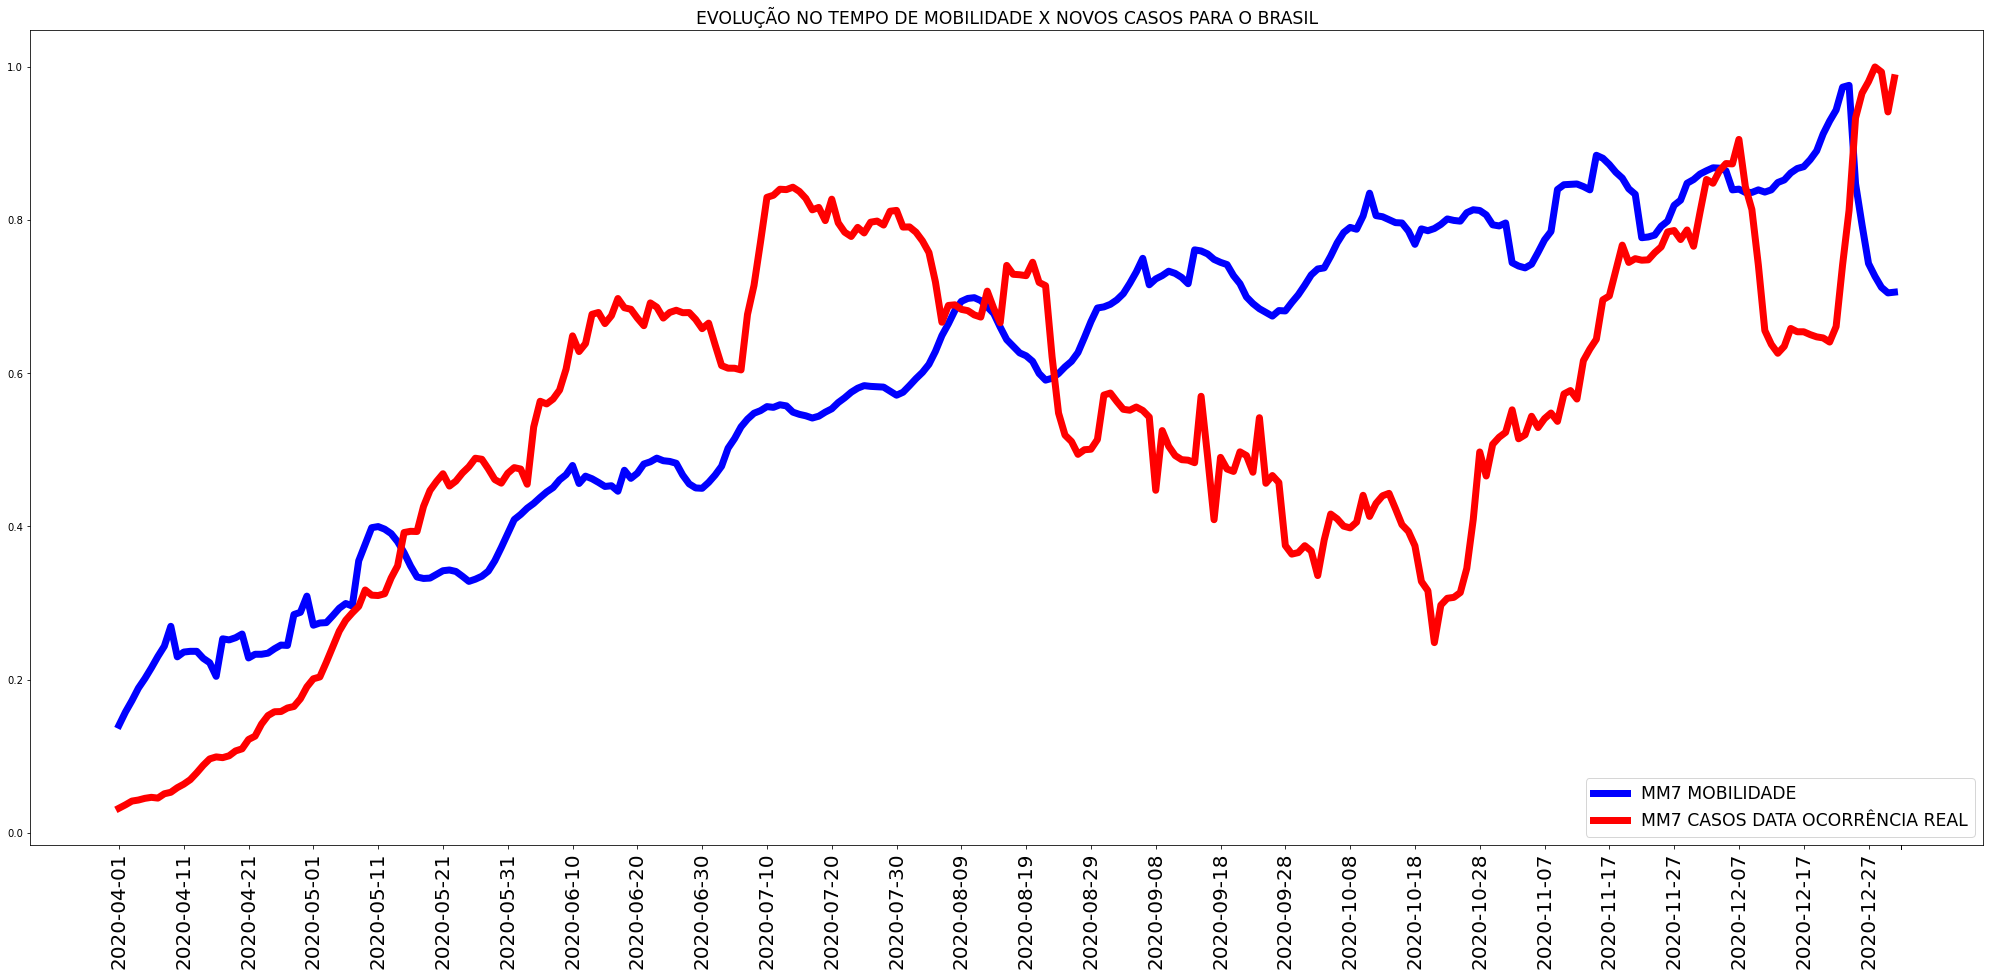

-------------------------------------------------------------------------------------------------------------------------------
CORRELAÇÃO LINEAR ENTRE AS MÉDIAS MÓVEIS DE VARIAÇÃO DE MOBILIDADE E DE CASOS NOVOS PARA O  BRASIL 
Período de 2020-04-01 a 2020-12-31 : 0.5589887017404818
-------------------------------------------------------------------------------------------------------------------------------


>>> A escala de cores do gráfico corresponde ao tempo (valores maiores == datas mais recentes) <<<




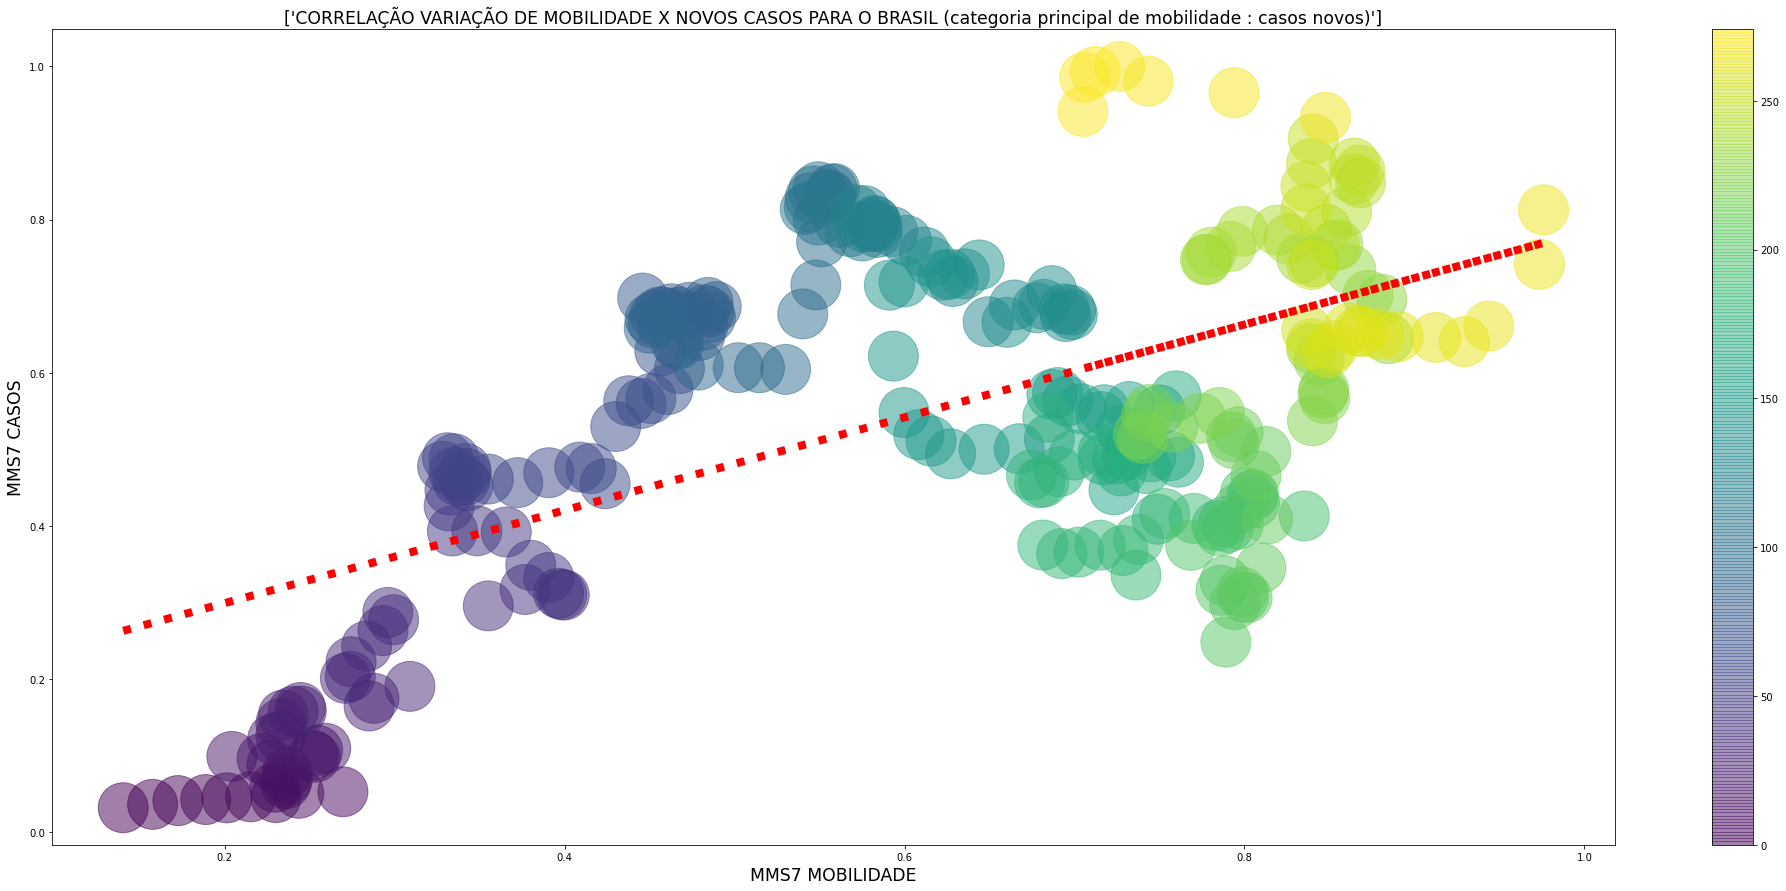

In [52]:
plotPais('Brasil')

In [40]:
colunas = colunas[:-5]

******************************************************************************************************************************
MAPA DE CORRELAÇÕES ENTRE AS CATEGORIAS DE VARIAÇÃO DE MOBILIDADE (RELATÓRIO GOOGLE) X NOVOS CASOS DE INFECÇÃO POR COVID - 19 (BASE OWID - OXFORD) NO  BRASIL - período de 2020-04-01 a 2020-12-31
******************************************************************************************************************************


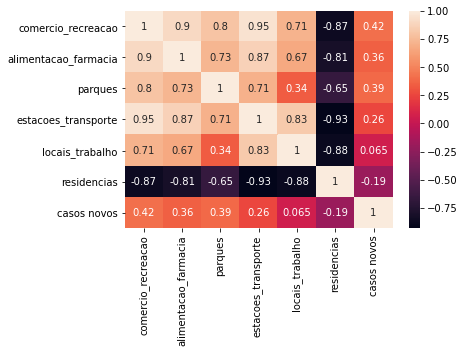

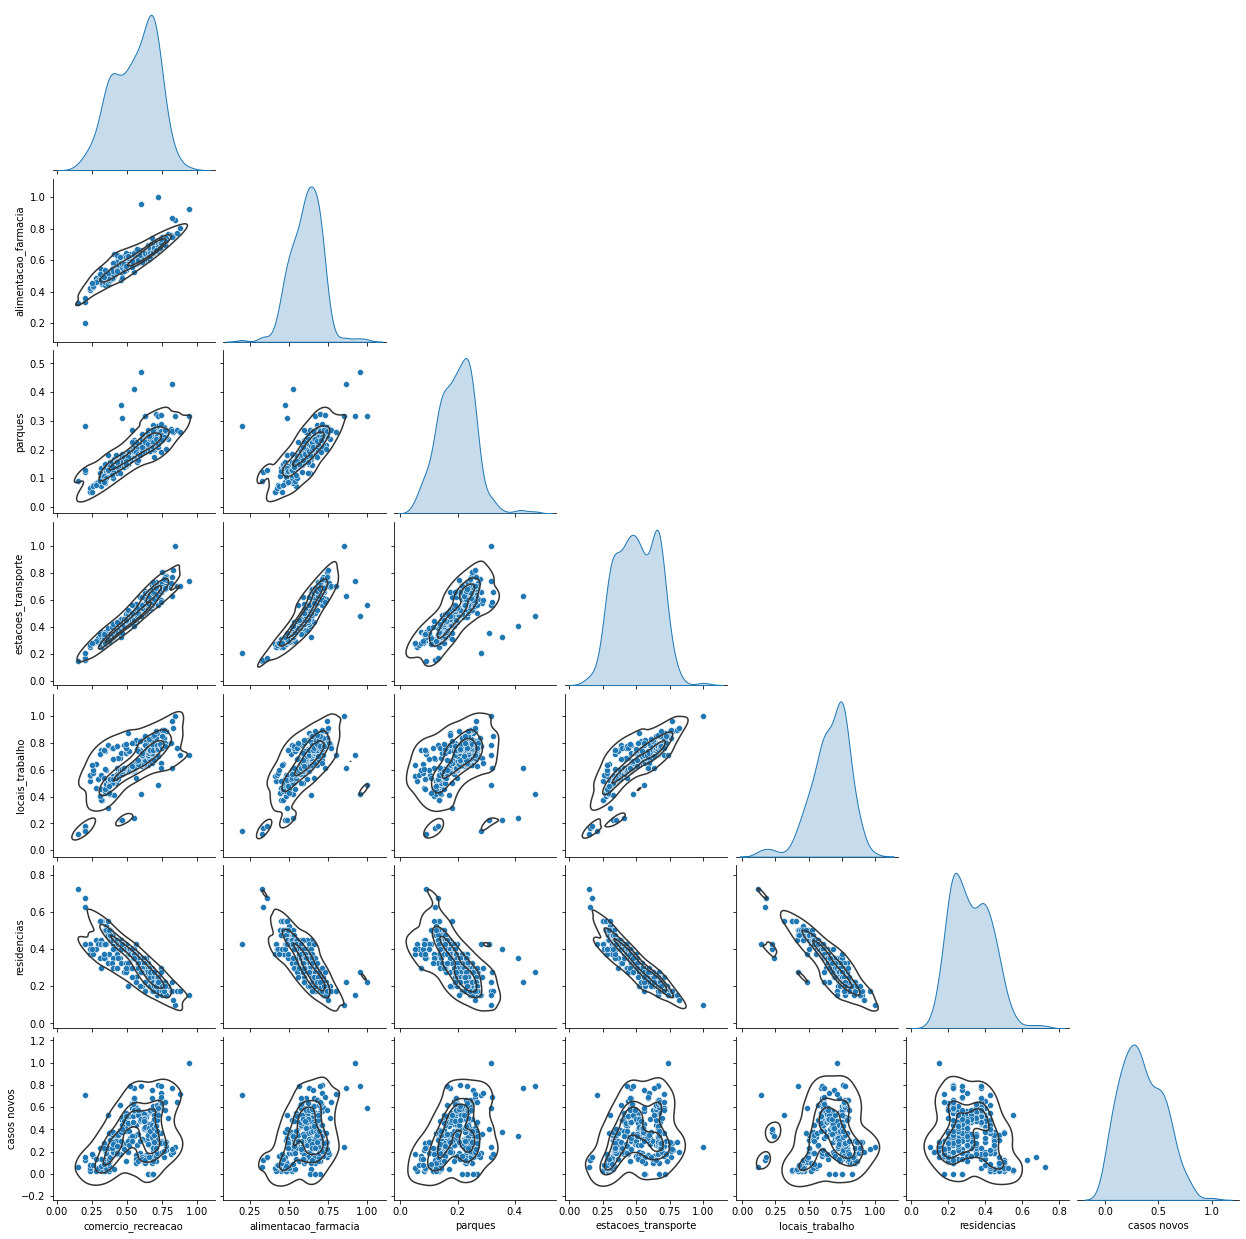

<Figure size 1440x648 with 0 Axes>

In [55]:
matrizCorrelacoes('Brasil')

******************************************************************************************************************************
ANÁLISE DE MOBILIDADE X NOVOS CASOS DE INFECÇÃO POR COVID - 19 PARA O :  CHILE  - período de  2020-04-01  a  2020-12-31 
(Fontes : GOOGLE MOBILITY REPORT + OUR WORLD IN DATA - OXFORD)
******************************************************************************************************************************


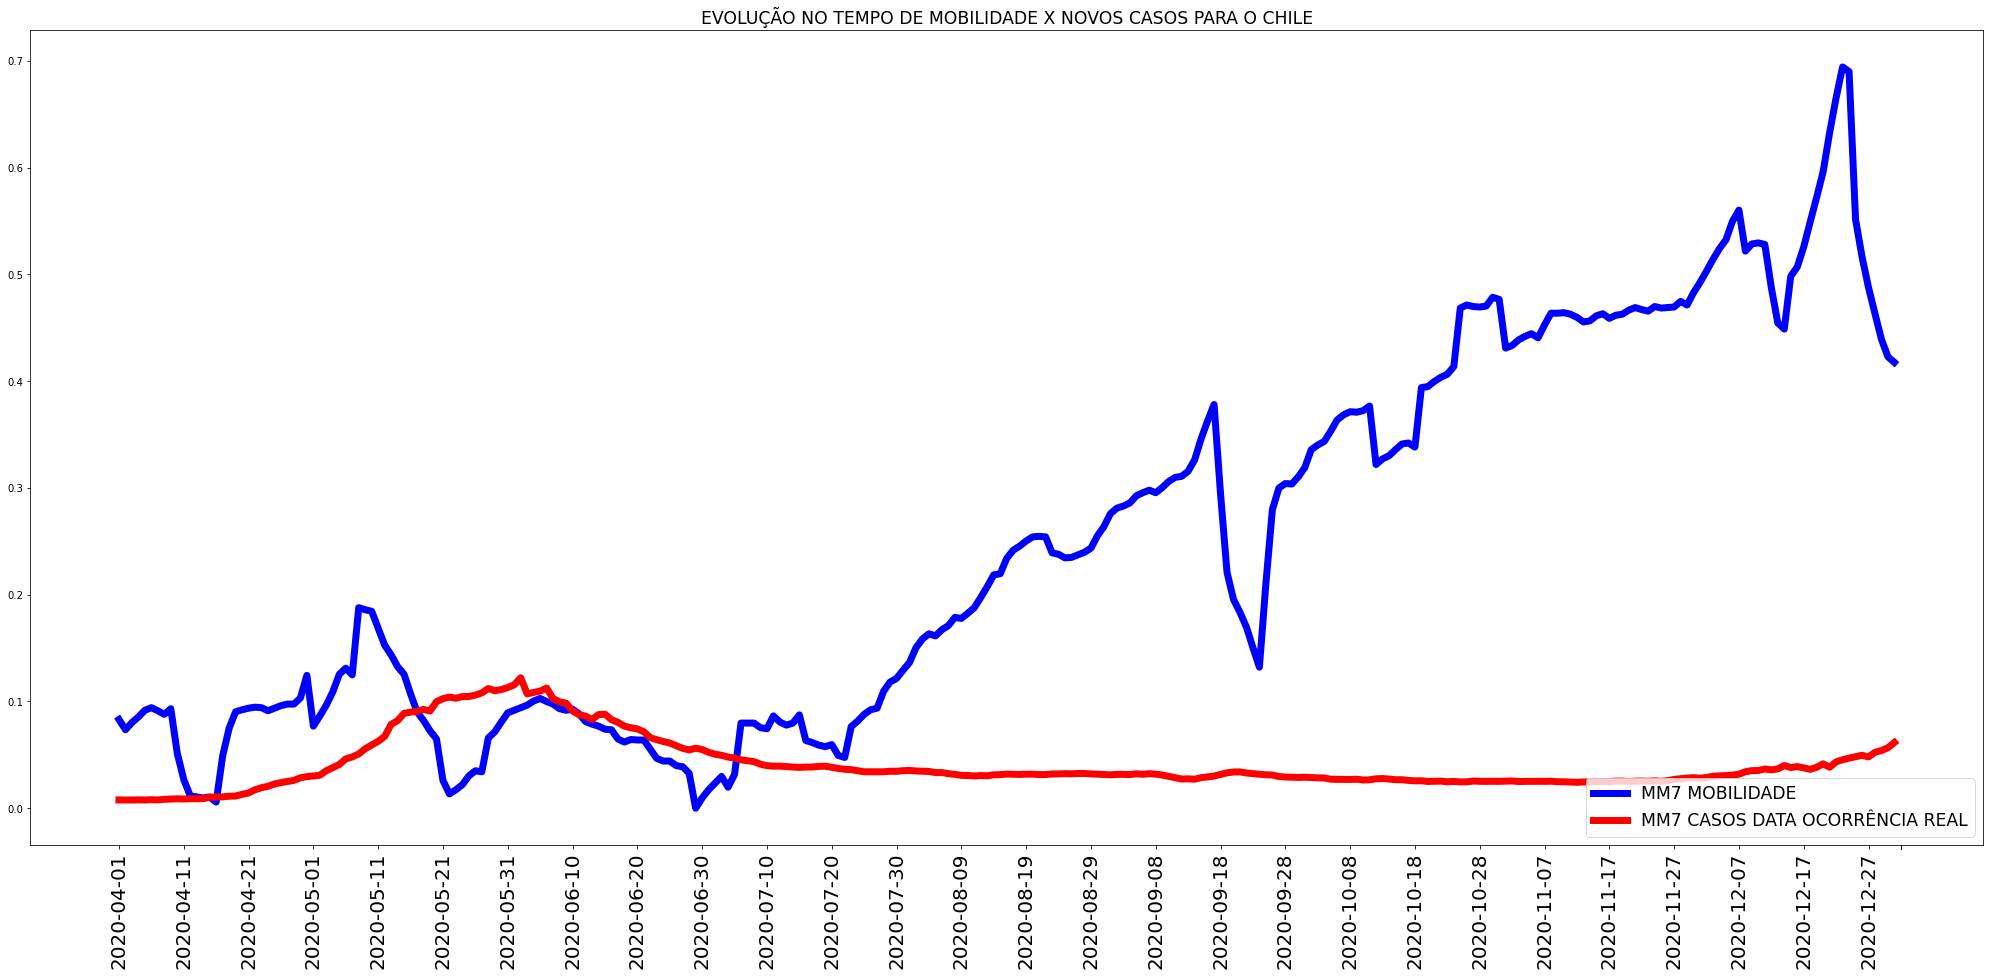

-------------------------------------------------------------------------------------------------------------------------------
CORRELAÇÃO LINEAR ENTRE AS MÉDIAS MÓVEIS DE VARIAÇÃO DE MOBILIDADE E DE CASOS NOVOS PARA O  CHILE 
Período de 2020-04-01 a 2020-12-31 : -0.3592111496275798
-------------------------------------------------------------------------------------------------------------------------------


>>> A escala de cores do gráfico corresponde ao tempo (valores maiores == datas mais recentes) <<<




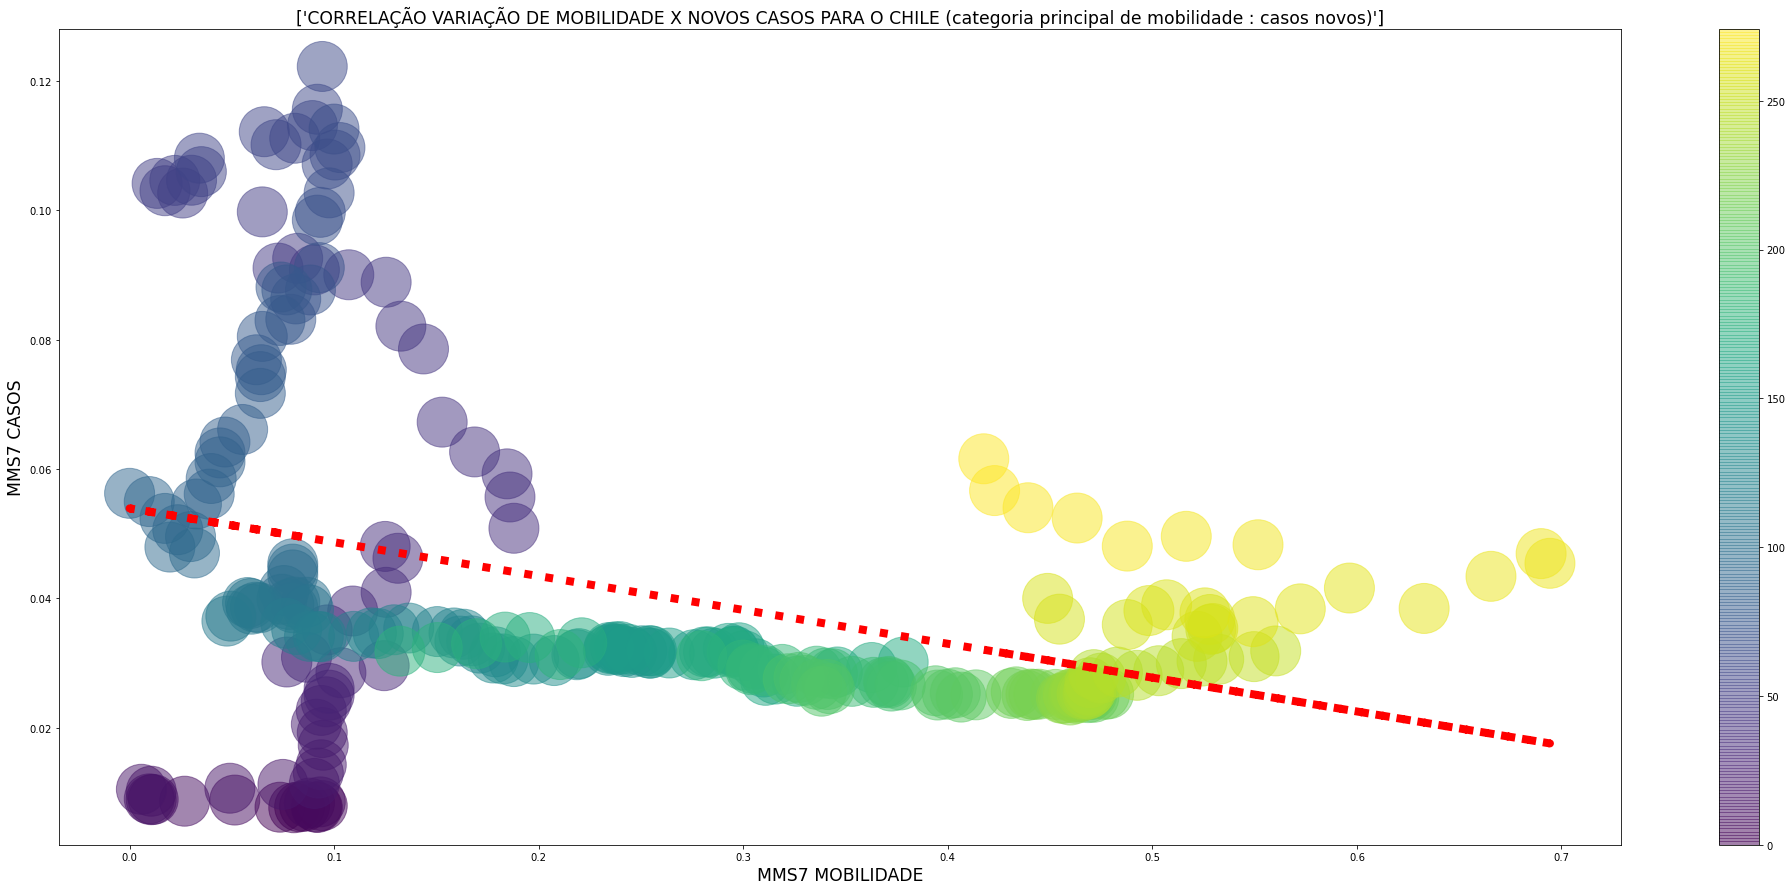

In [53]:
plotPais('Chile')

******************************************************************************************************************************
MAPA DE CORRELAÇÕES ENTRE AS CATEGORIAS DE VARIAÇÃO DE MOBILIDADE (RELATÓRIO GOOGLE) X NOVOS CASOS DE INFECÇÃO POR COVID - 19 (BASE OWID - OXFORD) NO  CHILE - período de 2020-04-01 a 2020-12-31
******************************************************************************************************************************


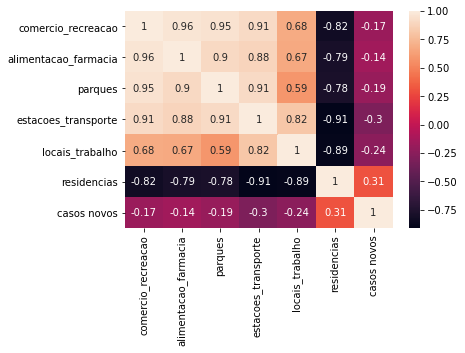

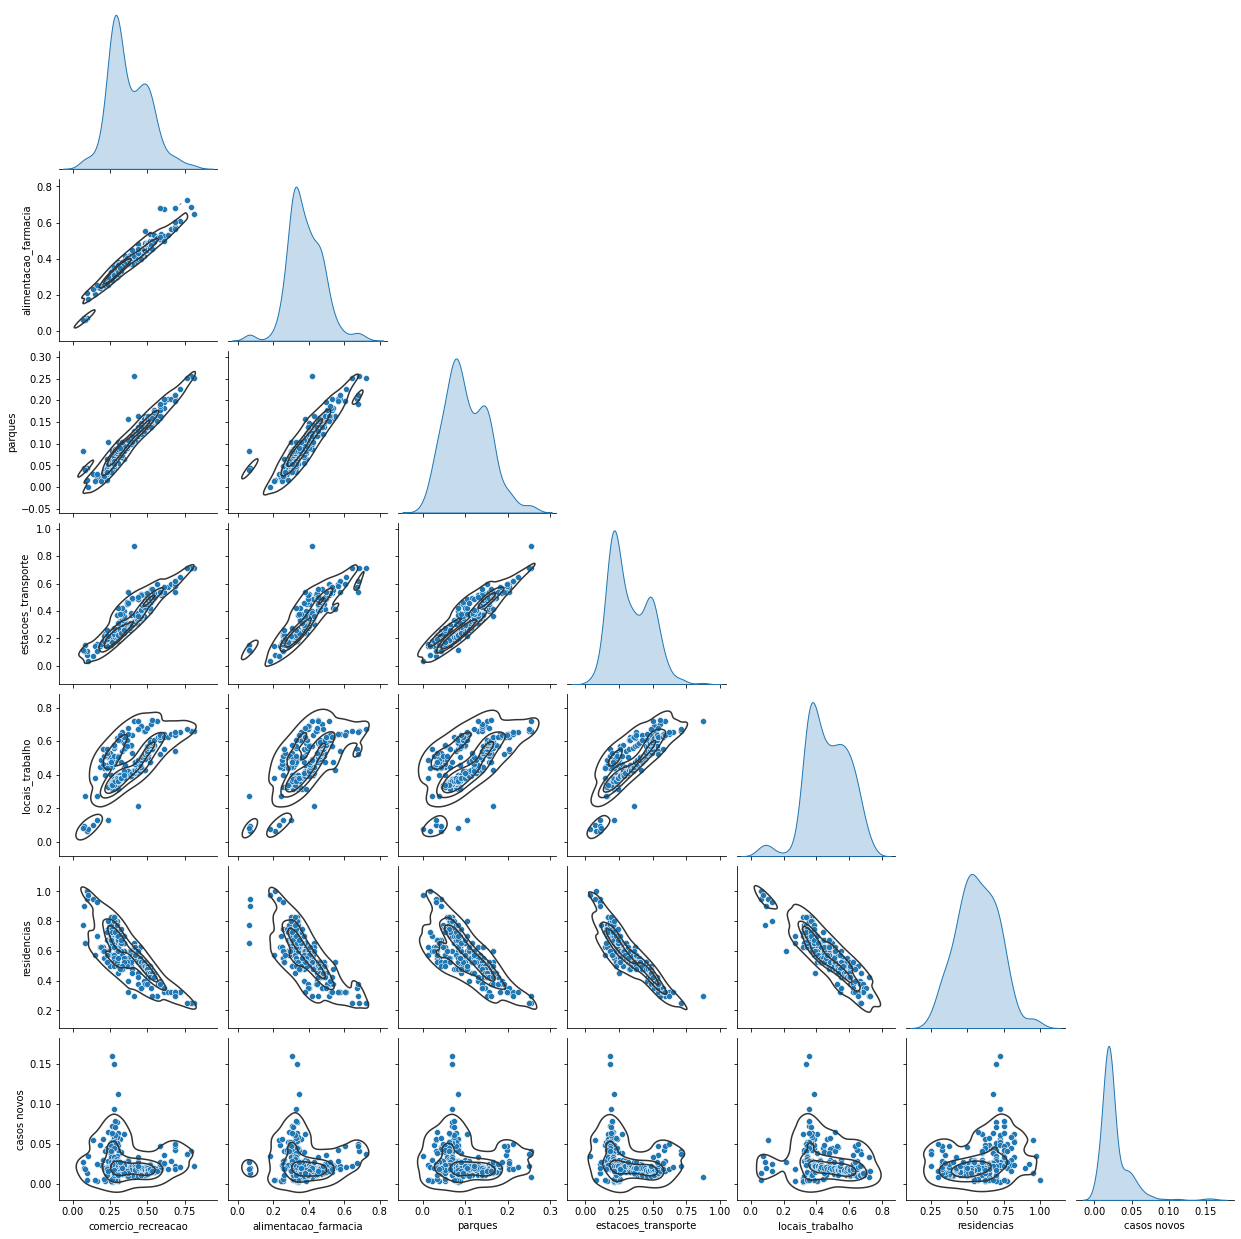

<Figure size 1440x648 with 0 Axes>

In [56]:
matrizCorrelacoes('Chile')

******************************************************************************************************************************
ANÁLISE DE MOBILIDADE X NOVOS CASOS DE INFECÇÃO POR COVID - 19 PARA O :  REINO UNIDO  - período de  2020-04-01  a  2020-12-31 
(Fontes : GOOGLE MOBILITY REPORT + OUR WORLD IN DATA - OXFORD)
******************************************************************************************************************************


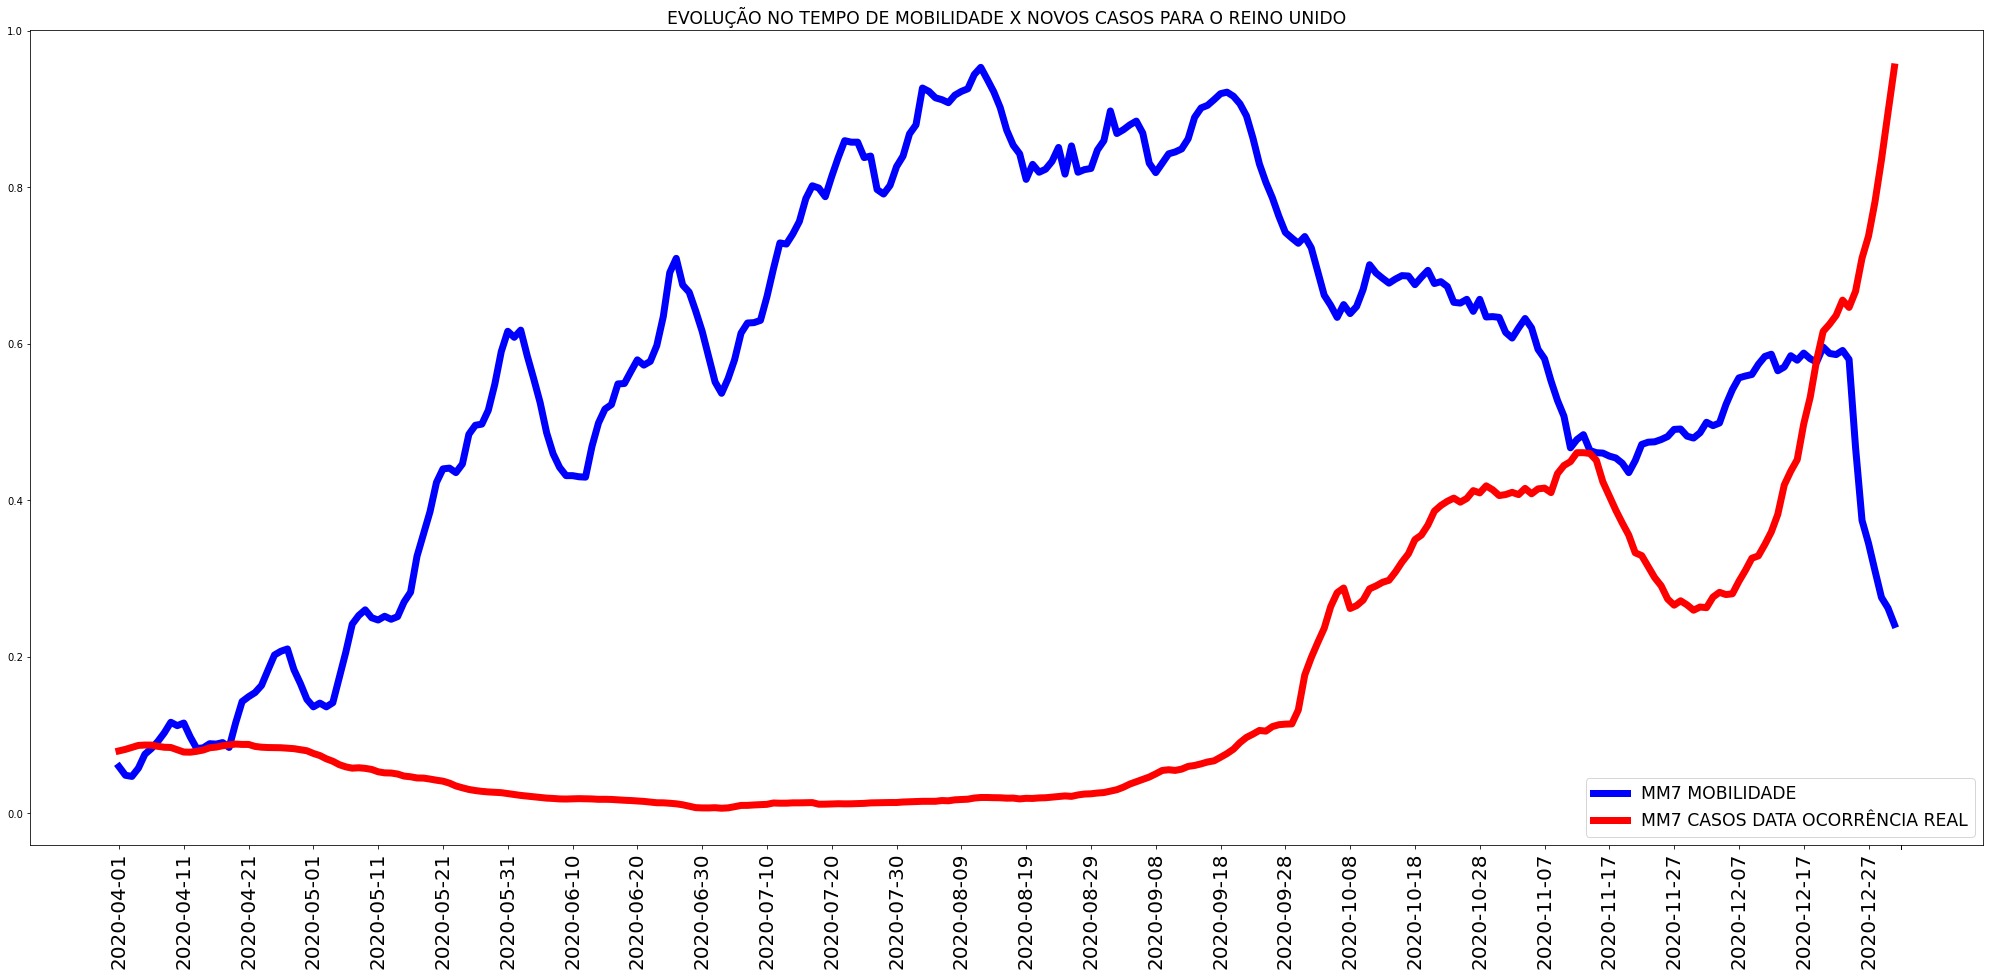

-------------------------------------------------------------------------------------------------------------------------------
CORRELAÇÃO LINEAR ENTRE AS MÉDIAS MÓVEIS DE VARIAÇÃO DE MOBILIDADE E DE CASOS NOVOS PARA O  REINO UNIDO 
Período de 2020-04-01 a 2020-12-31 : -0.1550953903056572
-------------------------------------------------------------------------------------------------------------------------------


>>> A escala de cores do gráfico corresponde ao tempo (valores maiores == datas mais recentes) <<<




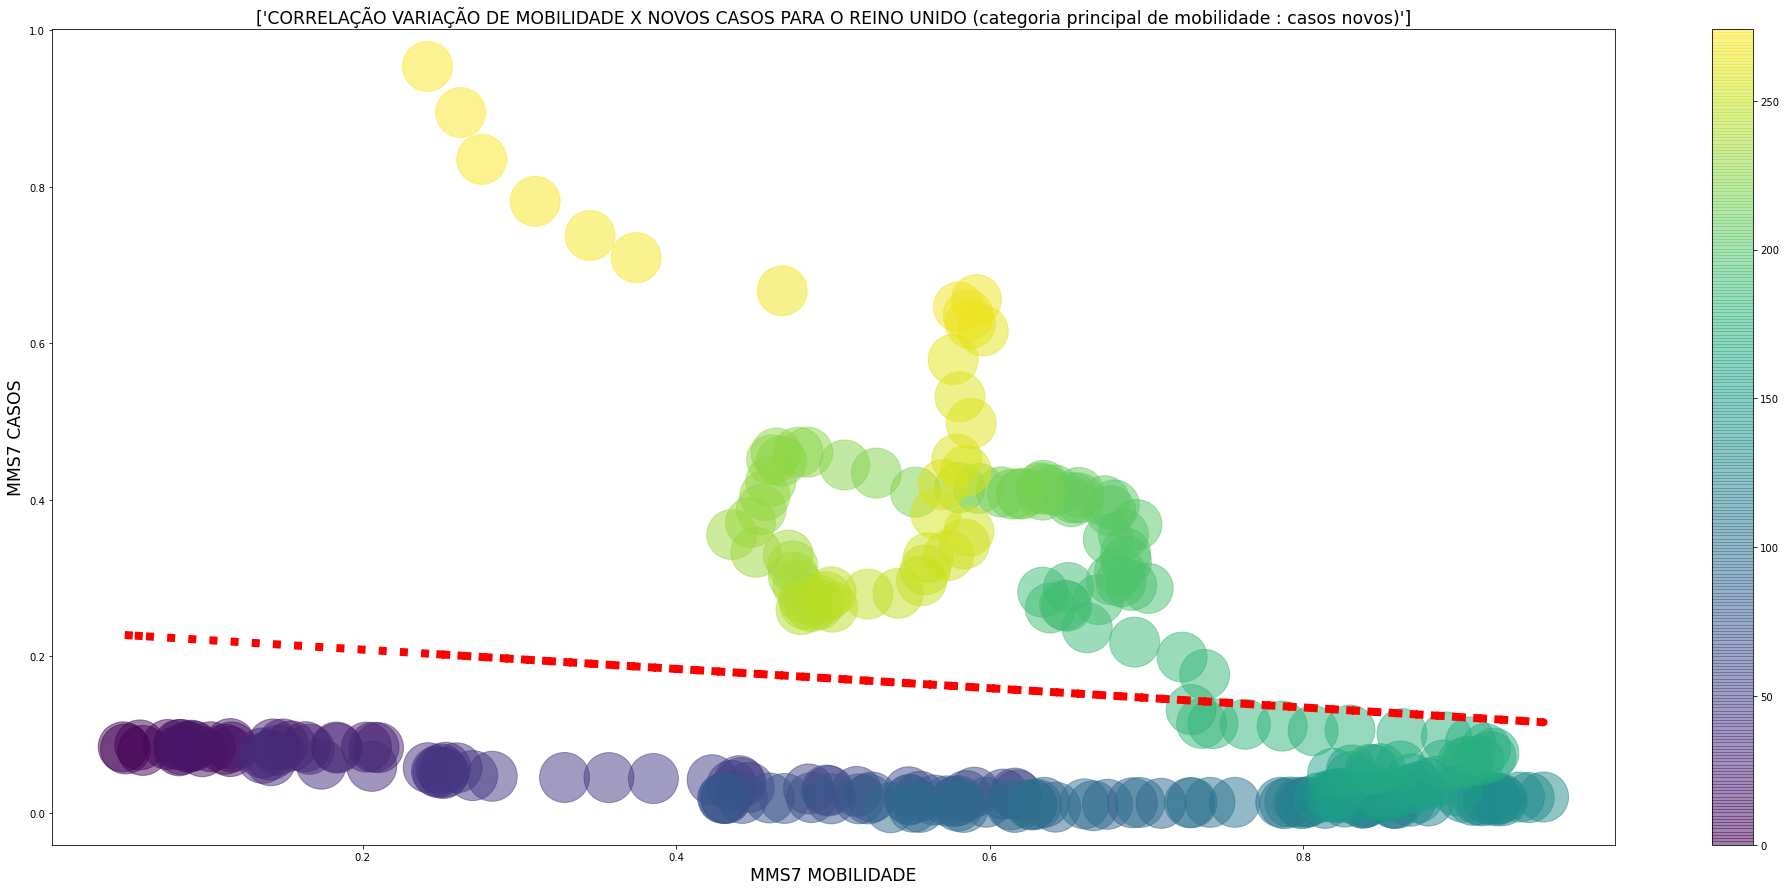

In [54]:
plotPais('Reino Unido')

******************************************************************************************************************************
MAPA DE CORRELAÇÕES ENTRE AS CATEGORIAS DE VARIAÇÃO DE MOBILIDADE (RELATÓRIO GOOGLE) X NOVOS CASOS DE INFECÇÃO POR COVID - 19 (BASE OWID - OXFORD) NO  REINO UNIDO - período de 2020-04-01 a 2020-12-31
******************************************************************************************************************************


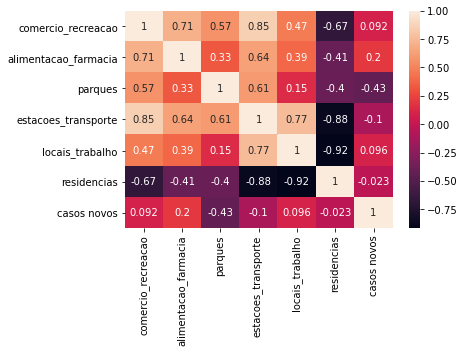

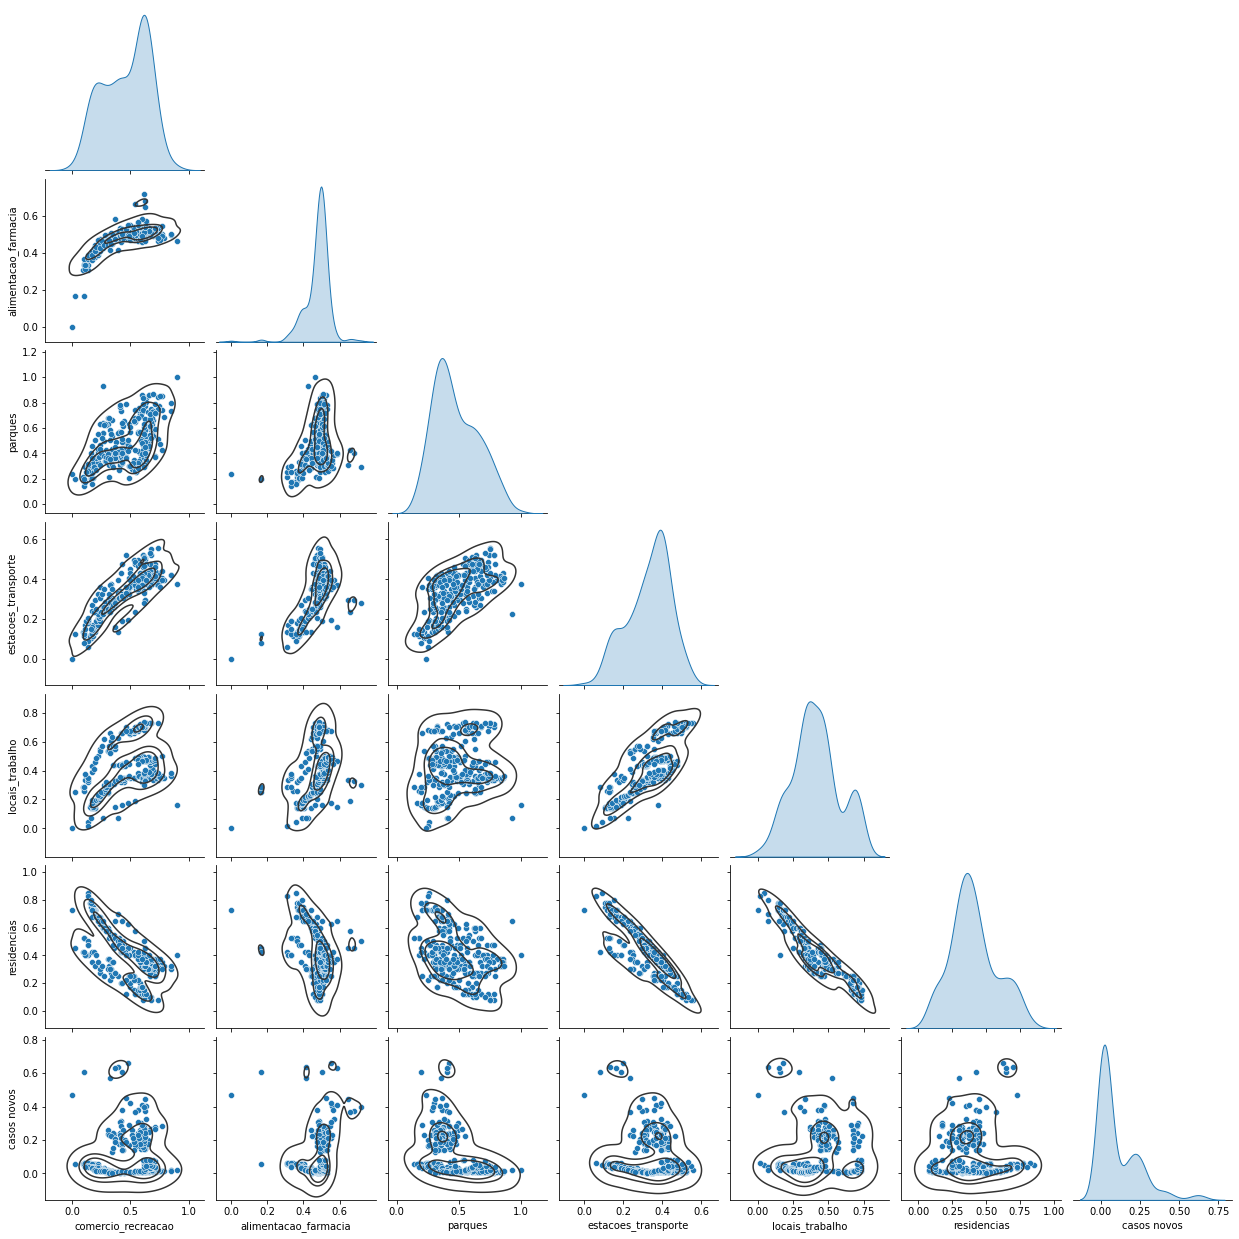

<Figure size 1440x648 with 0 Axes>

In [58]:
matrizCorrelacoes('Reino Unido')